In [1]:
# import libraries needed
from pathlib import Path
import os, yaml, time, sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
import scipy.stats as stats
#from .utils import *
# load in data
file_name = '../../Data/CubicBox_(-250.0, 250.0)_(-250.0, 250.0)_(-250.0, 250.0).npz'
particle_subsample = np.load(file_name)
x, y, z = particle_subsample['x'], particle_subsample['y'], particle_subsample['z']
vx, vy, vz = particle_subsample['vx'], particle_subsample['vy'], particle_subsample['vz'] 
x_range,y_range,z_range=[min(x),max(x)],[min(y),max(y)],[min(z),max(z)]

Functions written by Rianna for linear reconstruction

In [2]:
# rianna's code
# called in the function below for the velocity field
def wave_num(kgrid):
    """
    A function that computes the magnitude of the angular wave number k from it's cartesian components on a grid

    :param kgrid: The k-space meshgrid
    """
    kx, ky = kgrid[0], kgrid[1]
    kz = np.zeros_like(kx) if len(kgrid)==2 else kgrid[2]
    return np.sqrt(kx ** 2 + ky ** 2 + kz ** 2)

In [3]:
# rianna's code
# called in the function below for the velocity field
def get_velocity_grids(field, edges):
    """
    A function that returns the grid over which the velocity field will be computed in both real and fourier 
    space. 

    :param field:    The grid corresponding to the matter density field (2D or 3D)
    :param edges:    The side-length of the grid cells used to compute the velocity field.
    """
    # compute the number of dimensions of the density_field 
    N = len(np.shape(field))
    if N not in [2, 3]: 
        raise ValueError("Density field does not appear to be either a 2D or 3D field. The density field has a shape {}".format(np.shape(field))) 
    # compute the side length of the density field (in Mpc) 
    L = np.max(edges) - np.min(edges)
    ngrid = len(edges) - 1
    # kgrid_arrays = [np.fft.fftfreq(ngrid, L / (ngrid-1)) for _ in range(N-1)]
    # kgrid_arrays.extend([np.fft.rfftfreq(ngrid, L / (ngrid-1))])
    # kgrid_arrays = [np.fft.fftfreq(ngrid, L / (ngrid-1)) for _ in range(N)]
    kgrid_arrays = [2 * np.pi * np.fft.fftfreq(ngrid, L / (ngrid)) for _ in range(N)]
    # generate the fourier-space velocity grid
    kgrid = np.meshgrid(*reversed(kgrid_arrays)) if N==2 else np.meshgrid(*kgrid_arrays)
    return kgrid

In [4]:
# rianna's code
# computes the linear velocity field
def compute_linear_velocity_field(delta, grid_edges, H0=67, omega_m=0.3):
    """
    A function that computes the linear peculiar velocity field across a grid, using a set cosmology
    and a given matter density field.

    :param delta:   The input matter density field (2D or 3D)
    :param grid_edges:    The edges of the bins used to compude the density field (1D array)
    :param H0:              The hubble constant used in the velocity field computation (default is 67
                            km/s/Mpc from Plank2018)
    :param omega_m:         The cosmological matter density parameter used in the velocity field 
                            computation (default is 0.3 from Plank2018)
    """
    print('Computing the linear velocity field...')
    # compute f
    f = omega_m ** 0.6
    # compute the number of dimensions of the density field 
    N = len(np.shape(delta))
    # compute the real space and fourier space grids needed to compute the velocity field.
    k_grid = get_velocity_grids(delta, grid_edges)
    # # compute the wavenumber at each grid point
    k = wave_num(k_grid)
    # compute the k-space density field
    # delta_k = fft.rfftn(delta)
    delta_k = fft.fftn(delta)
    # initialise the fourier space velocity array
    velocity_kx = np.zeros_like(delta_k)
    velocity_ky = np.zeros_like(delta_k)
    velocity_kz = np.zeros_like(delta_k)
    # create the mask for the non-zero wavenumbers
    mask = k != 0
    velocity_kx[mask] = 1j * f * H0 * delta_k[mask] * k_grid[0][mask] / k[mask] ** 2
    velocity_ky[mask] = 1j * f * H0 * delta_k[mask] * k_grid[1][mask] / k[mask] ** 2
    if N == 3: 
        velocity_kz[mask] = 1j * f * H0 * delta_k[mask] * k_grid[2][mask] / k[mask] ** 2
    # compute the inverse transformation to get the real space velocity field
    # vx = np.fft.irfftn(velocity_ky, delta.shape)
    # vy = np.fft.irfftn(velocity_kx, delta.shape)
    # vz = np.fft.irfftn(velocity_kz, delta.shape) if N == 3 else np.zeros_like(vx)
    vx = np.real(np.fft.ifftn(velocity_ky, delta.shape))
    vy = np.real(np.fft.ifftn(velocity_kx, delta.shape))
    vz = np.real(np.fft.ifftn(velocity_kz, delta.shape) if N == 3 else np.zeros_like(vx))
    const=1.814606001413012
    return [const*vx,const*vy,const*vz]

Functions for comparisons

In [5]:
# create initial histogram splitting the data
# returns the bins x bins x bins density histogram and 3 x bins histogram edges
def density_histogram(bin_num):
    combined=np.column_stack((x,y,z))
    hist,edges=np.histogramdd(combined, bins=[bin_num,bin_num,bin_num])
    return hist,edges

In [6]:
# create histogram for overdensity
# returns the bins x bins x bins overdensity histogram and 3 x bins histogram edges
def overdensity_histogram(bin_num):
    hist,edges=density_histogram(bin_num)
    smolboxvol=int(500/bin_num)**3
    densities=hist/smolboxvol
    otherav=len(x)/(500**3)
    overdense=densities/otherav-1
    return overdense,edges

In [7]:
# create arrays for which bin each particle belongs in
# returns 3 arrays for the x, y and z box corresponding to each particle
def binned_positions(bin_num,edges):
    x_indices=np.digitize(x,edges[0])-1
    y_indices=np.digitize(y,edges[1])-1
    z_indices=np.digitize(z,edges[2])-1
    bin_x = np.clip(x_indices, 0, bin_num-1)
    bin_y = np.clip(y_indices, 0, bin_num-1)
    bin_z = np.clip(z_indices, 0, bin_num-1)
    return bin_x,bin_y,bin_z

In [8]:
# obtain the reconstructed velocities
# the main value to assign first
bin_num=64

# create overdensity field
overdense,edges=overdensity_histogram(bin_num)

# get binned particles
bin_x,bin_y,bin_z=binned_positions(bin_num,edges)

# compute linear velocity field
rx,ry,rz=compute_linear_velocity_field(overdense,edges[0])

# assign reconstructed values to all corresponding boxes
bin_rvx=rx[bin_x,bin_y,bin_z]
bin_rvy=ry[bin_x,bin_y,bin_z]
bin_rvz=rz[bin_x,bin_y,bin_z]

# calculate difference between reconstructed velocity and true velocity for particle
#bin_dx=abs(bin_rvx-vx)
#bin_dy=abs(bin_rvy-vy)
#bin_dz=abs(bin_rvz-vz)

Computing the linear velocity field...


In [ ]:
# retrieve the mean and std in a particular box by collecting all particles in that box
# returns two values for the mean and std respectively 
def retrieve_diff_cell(cell1,cell2,cell3,bin_x=bin_x,bin_y=bin_y,bin_z=bin_z,bin_dx=bin_dx):
    mask=(bin_x==cell1)&(bin_y==cell2)&(bin_z==cell3)
    cell_particles=bin_dx[mask]/100
    cell_mean=np.mean(cell_particles)*100
    cell_std=np.std(cell_particles)*100
    cell_particles=cell_particles*100
    return cell_mean,cell_std
##treating rvx as the 'mean' vs just taking the difference?

Main code

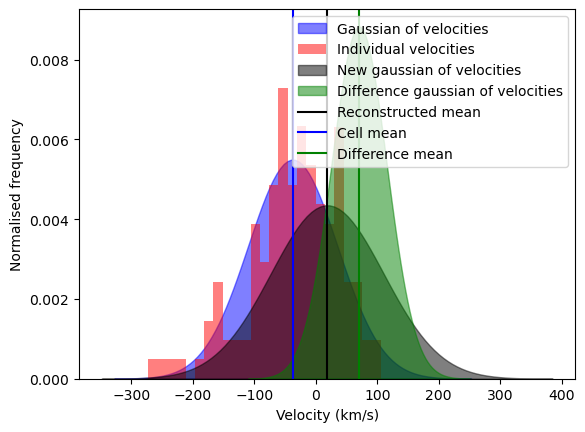

In [38]:
# create a plot of particles, their distribution, and the reconstructed velocity in a certain cell
# select cell to examine
cell1,cell2,cell3=52,31,12

# cut the data
mask=(bin_x==cell1)&(bin_y==cell2)&(bin_z==cell3)
cell_particles=vy[mask]/100

# compute mean and standard deviation in the cell
cell_mean=np.mean(cell_particles)*100
cell_std=np.std(cell_particles)*100
cell_particles=cell_particles*100

# construct gaussian for the cell
cell_range=np.linspace(cell_mean-4*cell_std,cell_mean+4*cell_std,100)
pdf = stats.norm.pdf(cell_range,cell_mean,cell_std)
# select corresponding reconstructed velocity
new_cell_mean=ry[cell1,cell2,cell3]
new_cell_std=new2[cell1,cell2,cell3]
cell_range_2=np.linspace(new_cell_mean-4*new_cell_std,new_cell_mean+4*new_cell_std,100)
pdf_2 = stats.norm.pdf(cell_range_2,new_cell_mean,new_cell_std)
#
extra1=deltay[cell1,cell2,cell3]
extra2=stdx[cell1,cell2,cell3]
cell_range_3=np.linspace(extra1-4*extra2,extra1+4*extra2,100)
pdf_3 = stats.norm.pdf(cell_range_3,extra1,extra2)

# plot particles, distribution and different means
plt.fill_between(cell_range,np.zeros(100),pdf,color='b',alpha=0.5,label='Gaussian of velocities')
plt.hist(cell_particles,bins=25,density=True,color='r',alpha=0.5,label='Individual velocities')
plt.fill_between(cell_range_2,np.zeros(100),pdf_2,color='k',alpha=0.5,label='New gaussian of velocities')
plt.fill_between(cell_range_3,np.zeros(100),pdf_3,color='g',alpha=0.5,label='Difference gaussian of velocities')
plt.axvline(x=new_cell_mean,color='k',label='Reconstructed mean')
plt.axvline(x=cell_mean,color='b',label='Cell mean')
plt.axvline(x=extra1,color='g',label='Difference mean')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalised frequency')
plt.legend()

# save figure
#path = '../Figures/ComparisonPlots/Y velocities in cell ({:.0f},{:.0f},{:.0f})'.format(cell1,cell2,cell3)
#plt.savefig(path, dpi=300)
plt.show()

In [10]:
# create a plot of the distribution of difference in x, y and z velocities
# histogram of log of each component
# this is technically grabbing every single particle difference as opposed to just comparing in a cell
#plt.hist(np.log10(bin_dx+1),bins=25,color='r',alpha=0.5,label='vx')
#plt.hist(np.log10(bin_dy+1),bins=25,color='g',alpha=0.5,label='vy')
#plt.hist(np.log10(bin_dz+1),bins=25,color='b',alpha=0.5,label='vz')
#plt.xlabel('$\log_{10} \Delta v$')
#plt.ylabel('Frequency')
#plt.legend()

# save figure
#path = '../Figures/ComparisonPlots/Delta velocity histogram'
#plt.savefig(path, dpi=300)
#plt.close()

Some more functions...

In [11]:
# calculate the mean and std in each box for each component
def full_recon_mean_std(bins,rvx,rvy,rvz,x=x,y=y,z=z,vx=vx,vy=vy,vz=vz):
    # lin recon gives velocity in every cell (basically a mean)
    # want to find difference between this val and every val put into that box
    # from that, find the mean and find the std
    # creates 6 bins x bins x bins matrices with the grouped velocities and stds 
    # returns the 6 matrices
    # BLUE CASE: distribution of the original data
    # BLACK CASE: distribution in difference post reconstruction
    hist,edges=density_histogram(bins)
    x_indices=np.digitize(x,edges[0])-1
    y_indices=np.digitize(y,edges[1])-1
    z_indices=np.digitize(z,edges[2])-1
    xidx = np.clip(x_indices, 0, bins-1)
    yidx = np.clip(y_indices, 0, bins-1)
    zidx = np.clip(z_indices, 0, bins-1)
    counts=np.zeros((bins,bins,bins))
    #black case
    directx=np.zeros((bins,bins,bins))
    directy=np.zeros((bins,bins,bins))
    directz=np.zeros((bins,bins,bins))
    stdxsq=np.zeros((bins,bins,bins))
    stdysq=np.zeros((bins,bins,bins))
    stdzsq=np.zeros((bins,bins,bins))
    stdx=np.zeros((bins,bins,bins))
    stdy=np.zeros((bins,bins,bins))
    stdz=np.zeros((bins,bins,bins))
    #blue case
    meanx=np.zeros((bins,bins,bins))
    meany=np.zeros((bins,bins,bins))
    meanz=np.zeros((bins,bins,bins))
    stdxbsq=np.zeros((bins,bins,bins))
    stdybsq=np.zeros((bins,bins,bins))
    stdzbsq=np.zeros((bins,bins,bins))
    stdxb=np.zeros((bins,bins,bins))
    stdyb=np.zeros((bins,bins,bins))
    stdzb=np.zeros((bins,bins,bins))
    np.add.at(counts, (xidx, yidx, zidx), 1)
    # black again but just std?
    stdxsq1=np.zeros((bins,bins,bins))
    stdysq1=np.zeros((bins,bins,bins))
    stdzsq1=np.zeros((bins,bins,bins))
    stdx1=np.zeros((bins,bins,bins))
    stdy1=np.zeros((bins,bins,bins))
    stdz1=np.zeros((bins,bins,bins))
    # black mean
    np.add.at(directx, (xidx, yidx, zidx), abs(vx-rvx[xidx,yidx,zidx]))
    np.add.at(directy, (xidx, yidx, zidx), abs(vy-rvy[xidx,yidx,zidx]))
    np.add.at(directz, (xidx, yidx, zidx), abs(vz-rvz[xidx,yidx,zidx]))
    directx[counts > 0] /= counts[counts > 0]
    directy[counts > 0] /= counts[counts > 0]
    directz[counts > 0] /= counts[counts > 0]
    # blue mean
    np.add.at(meanx, (xidx, yidx, zidx), vx)
    np.add.at(meany, (xidx, yidx, zidx), vy)
    np.add.at(meanz, (xidx, yidx, zidx), vz)
    meanx[counts > 0] /= counts[counts > 0]
    meany[counts > 0] /= counts[counts > 0]
    meanz[counts > 0] /= counts[counts > 0]
    # black pt1
    np.add.at(stdxsq, (xidx, yidx, zidx), (abs(vx-rvx[xidx,yidx,zidx])-directx[xidx,yidx,zidx])**2)
    np.add.at(stdysq, (xidx, yidx, zidx), (abs(vy-rvy[xidx,yidx,zidx])-directy[xidx,yidx,zidx])**2)
    np.add.at(stdzsq, (xidx, yidx, zidx), (abs(vz-rvz[xidx,yidx,zidx])-directz[xidx,yidx,zidx])**2)
    stdx[counts > 0] = np.sqrt(stdxsq[counts > 0] / counts[counts>0])
    stdy[counts > 0] = np.sqrt(stdysq[counts > 0] / counts[counts>0])
    stdz[counts > 0] = np.sqrt(stdzsq[counts > 0] / counts[counts>0])
    # blue
    np.add.at(stdxbsq, (xidx, yidx, zidx), (vx-meanx[xidx,yidx,zidx])**2)
    np.add.at(stdybsq, (xidx, yidx, zidx), (vy-meany[xidx,yidx,zidx])**2)
    np.add.at(stdzbsq, (xidx, yidx, zidx), (vz-meanz[xidx,yidx,zidx])**2)
    stdxb[counts > 0] = np.sqrt(stdxbsq[counts > 0] / counts[counts>0])
    stdyb[counts > 0] = np.sqrt(stdybsq[counts > 0] / counts[counts>0])
    stdzb[counts > 0] = np.sqrt(stdzbsq[counts > 0] / counts[counts>0])
    # black pt2
    np.add.at(stdxsq1, (xidx, yidx, zidx), (vx-rvx[xidx,yidx,zidx])**2)
    np.add.at(stdysq1, (xidx, yidx, zidx), (vy-rvy[xidx,yidx,zidx])**2)
    np.add.at(stdzsq1, (xidx, yidx, zidx), (vz-rvz[xidx,yidx,zidx])**2)
    stdx1[counts > 0] = np.sqrt(stdxsq1[counts > 0] / counts[counts>0])
    stdy1[counts > 0] = np.sqrt(stdysq1[counts > 0] / counts[counts>0])
    stdz1[counts > 0] = np.sqrt(stdzsq1[counts > 0] / counts[counts>0])
    # directx, directy, directz, stdx, stdy, stdz returns what originally doing
    # directx, directy, directz, stdx1, stdy1, stdz1 returns the new 'black case' (but should be identical to the one above)
    # meanx, meany, meanz, stdxb, stdyb, stdzb, returns the 'blue case'
    ## aaaactually what i'm calculating isnt a difference at all its using the reconstructed as the mean instead then going from there...
    return meanx, meany, meanz, stdxb, stdyb, stdzb

In [67]:
def velocity_comparison_histogram(meanx,meany,meanz,rvx,rvy,rvz):
    fig,axes=plt.subplots(1,3,figsize=(18,4))
    axes[0].hist(rvx.flatten(),bins=50,color='r',alpha=0.5,label='Recon vx')
    axes[0].hist(meanx.flatten(),bins=25,edgecolor='r',label='Mean vx',fill=False)
    axes[0].set_xlabel('$\log_{10}$ velocity')
    axes[0].set_ylabel('Frequency',labelpad=-7)
    axes[0].legend()
    axes[1].hist(rvy.flatten(),bins=50,color='g',alpha=0.5,label='Recon vy')
    axes[1].hist(meany.flatten(),bins=25,edgecolor='g',label='Mean vy',fill=False)
    axes[1].set_xlabel('$\log_{10}$ velocity')
    axes[1].set_ylabel('Frequency',labelpad=-7)
    axes[1].legend()
    axes[2].hist(rvz.flatten(),bins=50,color='b',alpha=0.5,label='Recon vz')
    axes[2].hist(meanz.flatten(),bins=25,edgecolor='b',label='Mean vz',fill=False)
    axes[2].set_xlabel('$\log_{10}$ velocity')
    axes[2].set_ylabel('Frequency',labelpad=-7)
    axes[2].legend()
    plt.show()
    return

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_736/2249711178.py:5: SyntaxWarning: invalid escape sequence '\l'
  axes[0].set_xlabel('$\log_{10}$ velocity')
/tmp/ipykernel_736/2249711178.py:10: SyntaxWarning: invalid escape sequence '\l'
  axes[1].set_xlabel('$\log_{10}$ velocity')
/tmp/ipykernel_736/2249711178.py:15: SyntaxWarning: invalid escape sequence '\l'
  axes[2].set_xlabel('$\log_{10}$ velocity')


Back to main code...

In [12]:
# retrieve difference in velocities and standard deviation in difference in velocities
deltax,deltay,deltaz,stdx,stdy,stdz=full_recon_mean_std(64,rx,ry,rz)

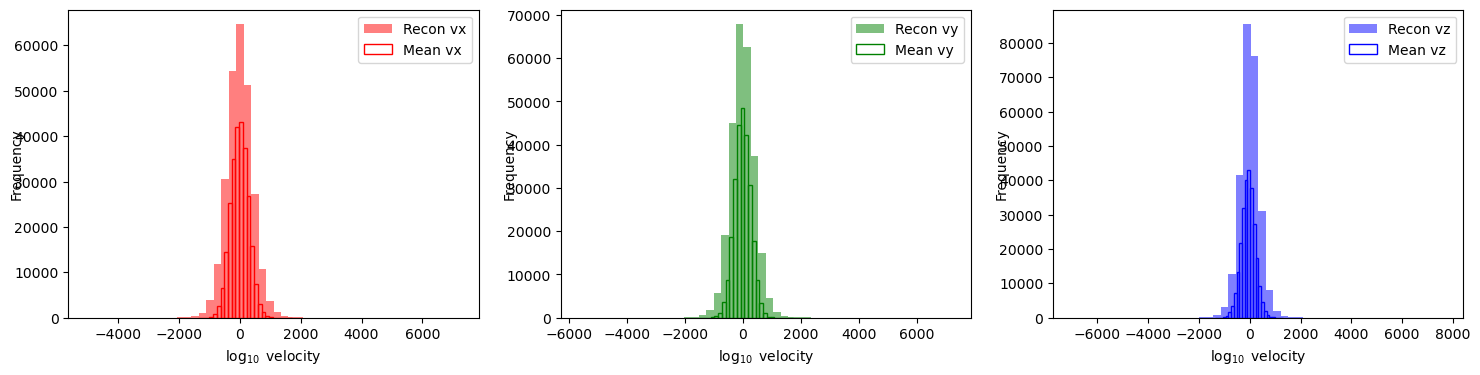

In [68]:
velocity_comparison_histogram(deltax,deltay,deltaz,rx,ry,rz)

In [29]:
deltax,deltay,deltaz,new1,new2,new3=full_recon_mean_std(64,rx,ry,rz)

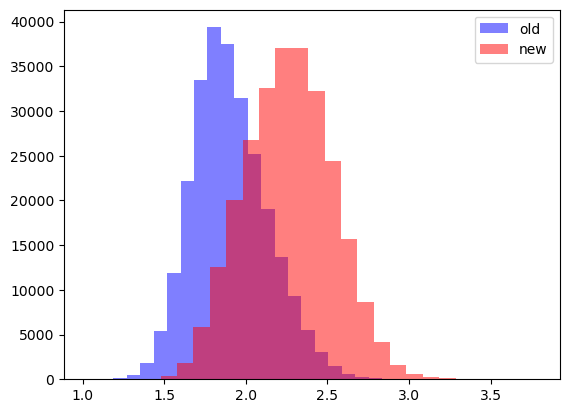

In [ ]:
plt.hist(np.log10(stdx.flatten()),bins=25,color='b',alpha=0.5,label='old')
plt.hist(np.log10(new1.flatten()),bins=25,color='r',alpha=0.5,label='new')
plt.legend()
plt.show()
# these are different, not sure...

In [ ]:
# confirm that this method is computing the correct means and stds by comparing it to individual cells
a,b,c=40,15,20
print(deltax[a,b,c],new1[a,b,c]) #this confirms its definitely different...
print(retrieve_diff_cell(a,b,c))

286.10724773269686 293.73162770022043
(286.10724773269783, 66.48993838349982)


In [15]:
# create a plot of the distribution of difference in x, y and z velocities
# histogram of log of each component
# this time, this is the full bins x bins x bins array being represented in this histogram
plt.hist(np.log10(deltax.flatten()+1),bins=25,color='r',alpha=0.5,label='vx')
plt.hist(np.log10(deltay.flatten()+1),bins=25,color='g',alpha=0.5,label='vy')
plt.hist(np.log10(deltaz.flatten()+1),bins=25,color='b',alpha=0.5,label='vz')
plt.xlabel('$\log_{10} \Delta v$')
plt.ylabel('Frequency')
plt.legend()

# save figure
path = '../Figures/ComparisonPlots/Binned delta velocity histogram'
plt.savefig(path, dpi=300)
plt.close()

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_168081/804109922.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10} \Delta v$')


In [16]:
# create a plot of the distribution of std in difference in x, y and z velocities
# histogram of log of each component
# this time, this is the full bins x bins x bins array being represented in this histogram
plt.hist(np.log10(stdx.flatten()+1),bins=25,color='r',alpha=0.5,label='vx')
plt.hist(np.log10(stdy.flatten()+1),bins=25,color='g',alpha=0.5,label='vy')
plt.hist(np.log10(stdz.flatten()+1),bins=25,color='b',alpha=0.5,label='vz')
plt.xlabel('$\log_{10} \sigma_{\Delta v}$')
plt.ylabel('Frequency')
plt.legend()

# save figure
path = '../Figures/ComparisonPlots/Binned sigma delta velocity histogram'
plt.savefig(path, dpi=300)
plt.close()

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_168081/1640504681.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log_{10} \sigma_{\Delta v}$')


In [17]:
# plot some slices with the new delta v and sigma delta v
z1=100
grid=500/bin_num
z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
vxslice,vyslice,vzslice=deltax[:,:,z_bin[0]],deltay[:,:,z_bin[0]],deltaz[:,:,z_bin[0]]
sxslice,syslice,szslice=stdx[:,:,z_bin[0]],stdy[:,:,z_bin[0]],stdz[:,:,z_bin[0]]
densityslice=overdense[:,:,z_bin[0]]
capped=[[600 if x > 600 else x for x in row] for row in vzslice]
capped1=[[600 if x > 600 else x for x in row] for row in szslice]
fig,axes=plt.subplots(1,3,figsize=(16,4))
ax1,ax2,ax3=axes[0],axes[1],axes[2]
im1=ax1.imshow(np.rot90(capped), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
ax1.set_xlabel('x coords')
ax1.set_ylabel('y coords',labelpad=-18)
ax1.set_title('Mean $\Delta v$')
fig.colorbar(im1,ax=ax1,label='$|\Delta v_{z}|$')
im2=ax2.imshow(np.rot90(capped1), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
ax2.set_xlabel('x coords')
ax2.set_ylabel('y coords',labelpad=-18)
ax2.set_title('STD $\Delta v$')
fig.colorbar(im2,ax=ax2,label='$\sigma_{|\Delta vz|}$')
im3=ax3.imshow(np.rot90(np.log10(densityslice+1)), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
ax3.set_xlabel('x coords')
ax3.set_ylabel('y coords',labelpad=-18)
ax3.set_title('Overdensity')
fig.colorbar(im3,ax=ax3,label='$\log_{10}(\delta+1)$')
path = '../Figures/ComparisonPlots/Mean and STD delta z-velocity with overdensity at z={:.0f}'.format(z1)
plt.savefig(path, dpi=300)
plt.close()

<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_168081/2655015023.py:15: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_title('Mean $\Delta v$')
/tmp/ipykernel_168081/2655015023.py:16: SyntaxWarning: invalid escape sequence '\D'
  fig.colorbar(im1,ax=ax1,label='$|\Delta v_{z}|$')
/tmp/ipykernel_168081/2655015023.py:20: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_title('STD $\Delta v$')
/tmp/ipykernel_168081/2655015023.py:21: SyntaxWarning: invalid escape sequence '\s'
  fig.colorbar(im2,ax=ax2,label='